In [1]:
import pandas as pd

pd.set_option("display.max_columns", None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

df = pd.read_csv("./data/dataset.csv").iloc[:, 1:].dropna()

In [2]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df, test_size=0.2)

In [3]:
from autogluon.tabular import TabularDataset, TabularPredictor

predictor = TabularPredictor.load("./Models")

C:\Users\MoonDongWon\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 기존 데이터 분포와 노이즈를 준 데이터의 분포

In [4]:
not_to_use = [
    "EX1.H4_PV",
    "EX1.H2O_PV",
    "EX1.MELT_P_PV",
    "EX1.H3_PV",
    "EX5.MELT_TEMP",
    "EX1.H2_PV",
    "EX4.MELT_TEMP",
    "EX1.Z3_PV",
    "EX2.MELT_TEMP",
    "EX3.MELT_TEMP",
    "EX1.MD_TQ",
]
og_data = train.loc[:, train.columns.difference(not_to_use)].iloc[:, :-1]

In [5]:
def plotting_hist(df):
    num_features = len(df.columns)

    nrows = 2
    ncols = (num_features + nrows - 1) // nrows

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4 * nrows))

    for idx, feature in enumerate(df.columns):
        row = idx // ncols
        col = idx % ncols
        ax = axes[row, col]

        data = df.loc[:, feature].values

        ax.hist(data, bins=1000, color="skyblue", edgecolor="black", alpha=0.7)
        title = ax.set_title(f"Histogram of {feature}")
        ax.set_xlabel(feature)
        ax.set_ylabel("Frequency")

    total_subplots = nrows * ncols
    if total_subplots > num_features:
        for i in range(num_features, total_subplots):
            row = i // ncols
            col = i % ncols
            axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()

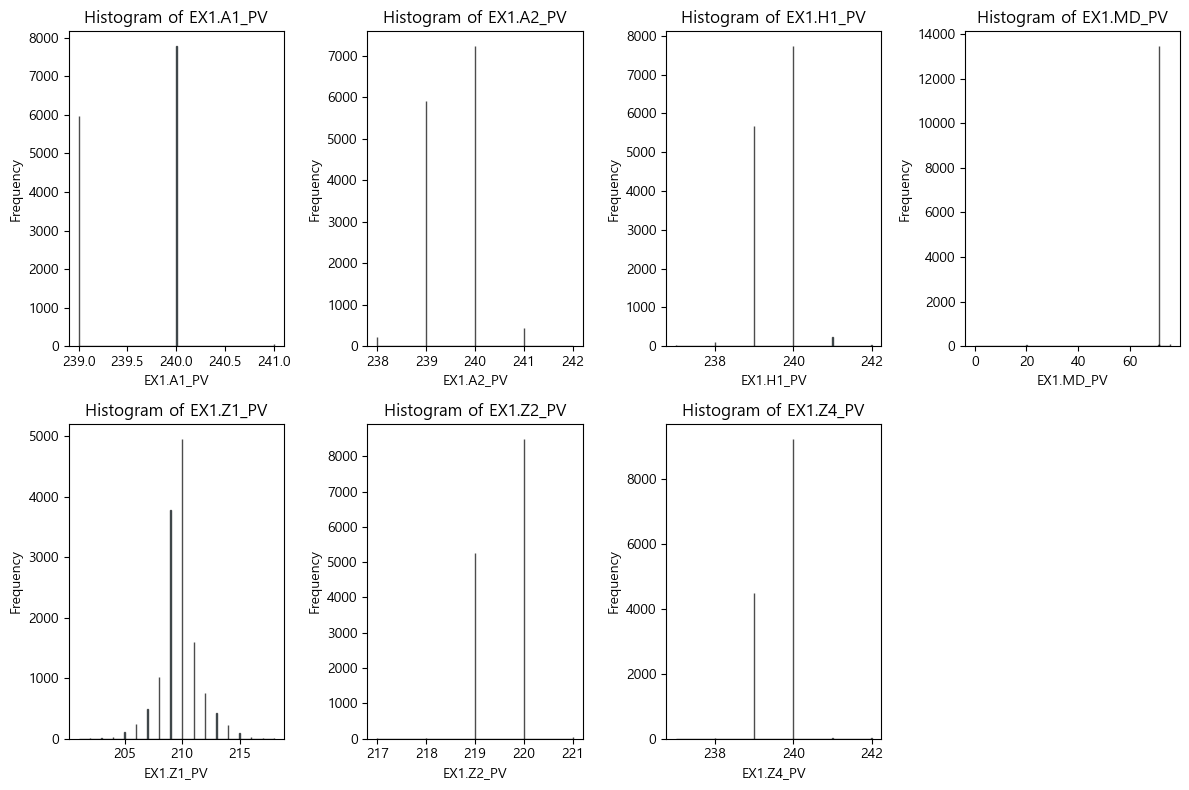

In [6]:
plotting_hist(og_data)

### 정규 분포 노이즈

In [7]:
from scipy import stats

# 예: 정규분포 적합
mu, std = stats.norm.fit(og_data)

noise = np.random.normal(loc=mu, scale=std, size=og_data.shape)
noisy_data = (og_data + noise) / 2

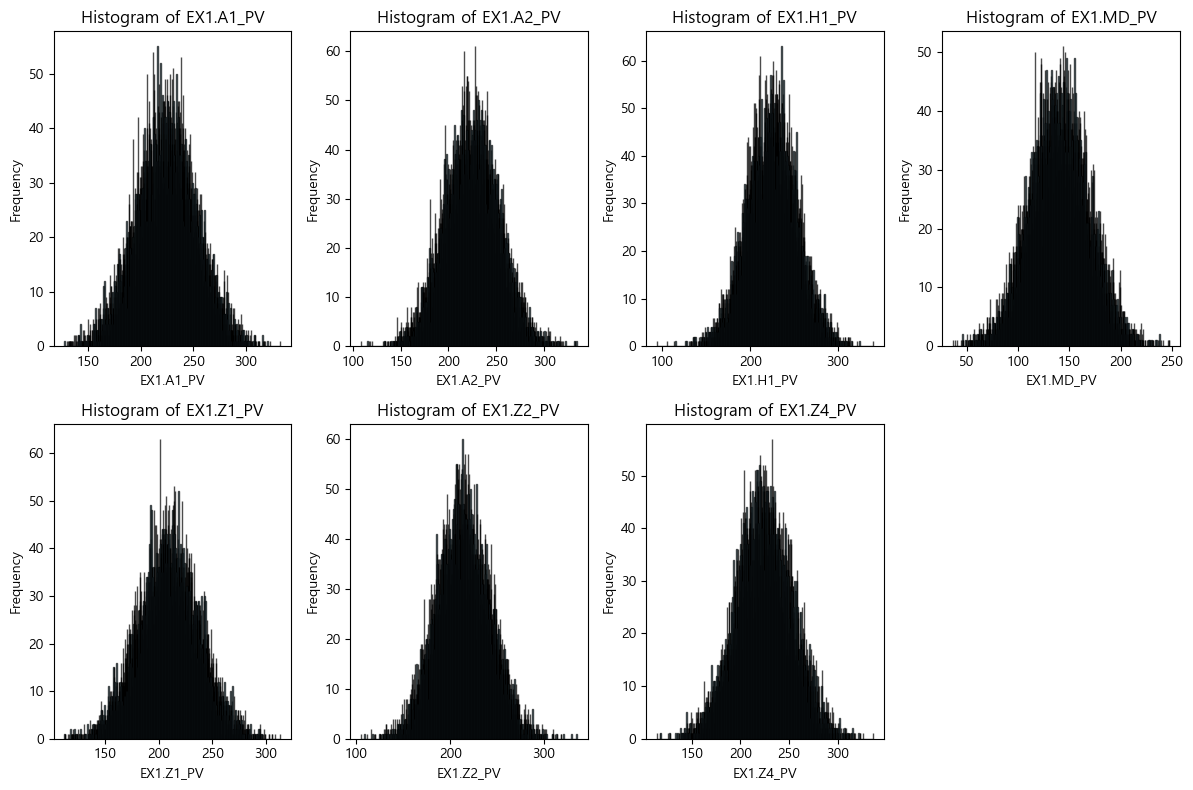

In [8]:
plotting_hist(noisy_data)

### KDE 노이즈

데이터 분포를 확인했을 때, 특정 분포로 적합하기 어려우므로, KDE 노이즈 사용

In [ ]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(og_data)


noise = kde.sample(n_samples=og_data.shape[0])
noise = pd.DataFrame(noise, columns=og_data.columns)


noisy_data = (og_data + noise) / 2

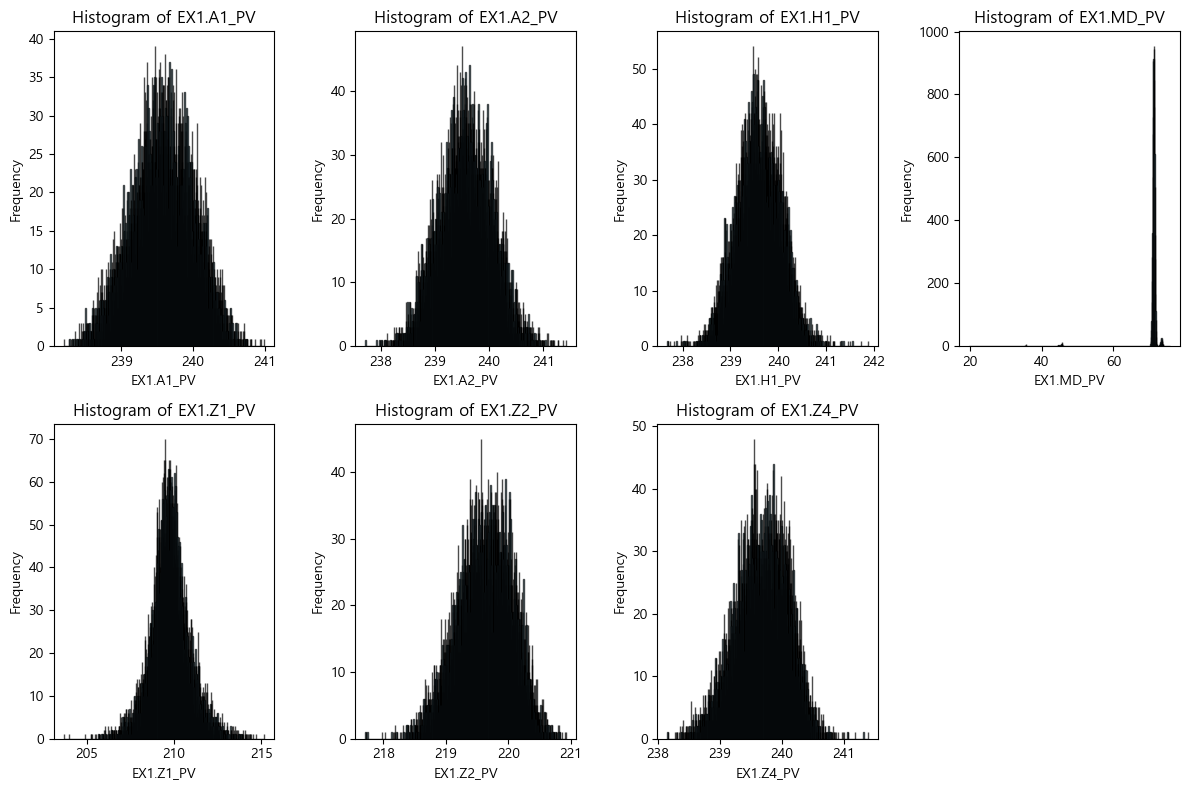

In [10]:
plotting_hist(noisy_data)

# NSGA 시뮬레이션

In [ ]:
import optuna

not_to_use = [
    "EX1.H4_PV",
    "EX1.H2O_PV",
    "EX1.MELT_P_PV",
    "EX1.H3_PV",
    "EX5.MELT_TEMP",
    "EX1.H2_PV",
    "EX4.MELT_TEMP",
    "EX1.Z3_PV",
    "EX2.MELT_TEMP",
    "EX3.MELT_TEMP",
    "EX1.MD_TQ",
    "passorfail",
]
simulation_cols = train.columns.difference(not_to_use)


def modify_data_based_on_bounds(valid: pd.DataFrame, bounds: dict) -> pd.DataFrame:
    """
    각 컬럼에 대해 원본 구간 [L, U]를 계산한 후,
      new_lower = L + factor_lower * (U - L)
      new_upper = L + factor_upper * (U - L)
    의 새로운 구간을 결정합니다.

    이후 해당 구간으로 정규화 → 로짓 변환 → KDE 샘플링 → 역변환을 적용하여
    노이즈가 포함된 데이터를 생성합니다.

    bounds 딕셔너리는 각 컬럼별로 (factor_lower, factor_upper)를 제공합니다.
    """
    df_mod = valid.copy()
    eps = 1e-6  # 0 또는 1이 되는 것을 방지

    for col in df_mod.columns:
        # bounds가 정의된 컬럼만 수정 (나머지는 그대로)
        if col not in bounds:
            continue
        if col in not_to_use:
            continue

        x = df_mod[col].astype(float).values
        orig_lower = np.min(x)
        orig_upper = np.max(x)
        orig_range = orig_upper - orig_lower
        if orig_range <= 0:
            continue

        # trial에서 제시한 상대적 비율값 (factor_lower, factor_upper)
        factor_lower, factor_upper = bounds[col]
        new_lower = orig_lower + factor_lower * orig_range
        new_upper = orig_lower + factor_upper * orig_range

        if new_lower >= new_upper:
            continue

        # [new_lower, new_upper] 구간으로 정규화 및 클리핑
        x_norm = (x - new_lower) / (new_upper - new_lower)
        x_norm = np.clip(x_norm, eps, 1 - eps)

        # 로짓 변환
        y = np.log(x_norm / (1 - x_norm)).reshape(-1, 1)

        # KDE를 이용한 노이즈 추가: y 공간에서 원본과 동일한 수의 샘플 생성
        kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(y)
        noise = kde.sample(n_samples=len(x))
        # 역로짓 변환 및 원본 스케일 복원
        x_sim_norm = 1 / (1 + np.exp(-noise))
        x_sim = x_sim_norm * (new_upper - new_lower) + new_lower

        df_mod[col] = (df_mod[col].values + x_sim) / 2
    return df_mod

In [ ]:
trial_bounds = []


def objective(trial):
    global trial_bounds

    bounds = {}
    margin = 0.5  # 기본 구간의 ±20%까지 확장/축소 허용
    for col in simulation_cols:
        # 각 컬럼에 대해 두 개의 상대적 위치 값을 제안
        r1 = trial.suggest_float(col + "_bound1", low=-margin, high=1 + margin)
        r2 = trial.suggest_float(col + "_bound2", low=-margin, high=1 + margin)
        factor_lower = min(r1, r2)
        factor_upper = max(r1, r2)
        bounds[col] = (factor_lower, factor_upper)

    trial_bounds.append(bounds)

    # [시뮬레이션 영역의 폭] 계산: 각 컬럼의 새 구간 폭의 합
    sim_range_sum = 0
    for col in simulation_cols:
        x = train[col].astype(float).values
        orig_lower = np.min(x)
        orig_upper = np.max(x)
        orig_range = orig_upper - orig_lower
        factor_lower, factor_upper = bounds[col]
        new_range = (factor_upper - factor_lower) * orig_range
        sim_range_sum += new_range

    # trial에서 제시한 bounds를 반영해 검증 데이터 변형
    modified_val_features = modify_data_based_on_bounds(valid, bounds)

    predictions = predictor.predict(modified_val_features)

    acceptance_rate = 1 - (sum(predictions) / len(predictions))

    # 다목적 최적화 대상 (각 목표에 대해 방향을 아래와 같이 설정)
    # 1. acceptance_rate: 최대화
    # 2. sim_range_sum: 최대화 (더 넓은 시뮬레이션 영역)
    return acceptance_rate, sim_range_sum

In [40]:
# Optuna를 통한 상한/하한 최적화
from optuna.samplers import NSGAIIISampler, NSGAIISampler

study = optuna.create_study(
    sampler=NSGAIISampler(population_size=10),
    directions=[
        "maximize",
        "maximize",
    ],
)
study.optimize(objective, n_trials=100)

# 최적의 상한/하한 값 확인
print("Best trial len:", len(study.best_trials))
print("Best trial:", study.best_trials[0].params)

[I 2025-02-17 13:26:34,612] A new study created in memory with name: no-name-044b7d8a-35d0-4212-a479-b8fc329ff459
[I 2025-02-17 13:26:39,702] Trial 0 finished with values: [0.9985519837822183, 48.16868652670747] and parameters: {'EX1.A1_PV_bound1': -0.16654984739003886, 'EX1.A1_PV_bound2': 0.7757976683426968, 'EX1.A2_PV_bound1': 0.7480972249905378, 'EX1.A2_PV_bound2': 1.2147926778297091, 'EX1.H1_PV_bound1': 0.47561344017060203, 'EX1.H1_PV_bound2': 1.2365500974492039, 'EX1.MD_PV_bound1': 0.688804133380936, 'EX1.MD_PV_bound2': 0.8754684639586892, 'EX1.Z1_PV_bound1': 0.7992909885008774, 'EX1.Z1_PV_bound2': -0.16425316308695748, 'EX1.Z2_PV_bound1': -0.4231729379927671, 'EX1.Z2_PV_bound2': 1.3876622031144963, 'EX1.Z4_PV_bound1': 0.7420172178701623, 'EX1.Z4_PV_bound2': 1.3169691966354893}.
[I 2025-02-17 13:26:44,935] Trial 1 finished with values: [0.8760498117578916, 33.374846149962295] and parameters: {'EX1.A1_PV_bound1': 1.2398372233850417, 'EX1.A1_PV_bound2': -0.22677297767241966, 'EX1.A2

Best trial len: 7
Best trial: {'EX1.A1_PV_bound1': 0.7651219480239209, 'EX1.A1_PV_bound2': -0.24672434571835344, 'EX1.A2_PV_bound1': 0.1655331460525129, 'EX1.A2_PV_bound2': 1.1488544828029452, 'EX1.H1_PV_bound1': 1.1608498763382735, 'EX1.H1_PV_bound2': -0.12638295015247447, 'EX1.MD_PV_bound1': 1.0775909786165536, 'EX1.MD_PV_bound2': 0.35811181491387045, 'EX1.Z1_PV_bound1': 1.3677334573561983, 'EX1.Z1_PV_bound2': -0.31587245489668714, 'EX1.Z2_PV_bound1': 0.18819807612438888, 'EX1.Z2_PV_bound2': 0.5058600632283896, 'EX1.Z4_PV_bound1': -0.04619965059644149, 'EX1.Z4_PV_bound2': 0.8141814503279305}


In [41]:
from plotly.io import show
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

fig = optuna.visualization.plot_pareto_front(
    study,
    targets=lambda t: (t.values[0], t.values[1]),
    target_names=["합격률", "새롭게 설정한 상/하한 범위의 합"],
)

show(fig)

In [42]:
from skcriteria import mkdm
from skcriteria.madm import simple
from skcriteria.agg import similarity
from skcriteria.preprocessing import scalers

pareto_solutions = []
for trial in study.best_trials:
    # trial의 모든 파라미터와 목표 값 (불량률 및 비용)을 함께 저장
    solution = trial.params
    solution["Defect_Rate"] = trial.values[0]  # 불량률
    solution["Cost"] = trial.values[1]  # 비용
    pareto_solutions.append(solution)

pareto_df = pd.DataFrame(pareto_solutions)

# 4. TOPSIS 적용
# `Defect_Rate`는 최소화, `Cost`는 최대화가 목표이므로 각각의 목표 설정
# 양의 이상적 솔루션으로 부터 가장 짧은 거리, 음의 이상적 솔루션으로 부터 가장 긴 거리
criteria_data = pareto_df[["Defect_Rate", "Cost"]].values
criteria_names = ["Defect_Rate", "Cost"]
criteria_min_max = [min, max]  # 최소화/최대화 설정

# 데이터 스케일링 및 TOPSIS 모델 설정
dm = mkdm(
    matrix=criteria_data,
    objectives=criteria_min_max,
    criteria=criteria_names,
    alternatives=pareto_df.index,  # trial 인덱스 사용
)

# 데이터 정규화 및 TOPSIS 적용
scaler = scalers.SumScaler(target="both")
dm = scaler.transform(dm)
topsis = similarity.TOPSIS()
decision = topsis.evaluate(dm)

# 결과 처리: 각 trial의 TOPSIS 점수 및 랭킹 추가
pareto_df["TOPSIS_Score"] = decision.e_.similarity  # 유사도 인덱스가 점수
pareto_df["Rank"] = pareto_df["TOPSIS_Score"].rank(ascending=False)  # 내림차순으로 랭크

# 최적 타협 해 선택
optimal_solution = pareto_df.sort_values(by="TOPSIS_Score", ascending=False).iloc[0]
print("TOPSIS 최적 타협 해:\n", optimal_solution)

# 전체 Pareto 해 집합과 TOPSIS 결과 표시
print("Pareto 해 집합과 TOPSIS 결과:\n", pareto_df)

TOPSIS 최적 타협 해:
 EX1.A1_PV_bound1      0.765122
EX1.A1_PV_bound2      1.296511
EX1.A2_PV_bound1      0.165533
EX1.A2_PV_bound2      0.056036
EX1.H1_PV_bound1      1.318087
EX1.H1_PV_bound2     -0.144806
EX1.MD_PV_bound1      1.479522
EX1.MD_PV_bound2     -0.417580
EX1.Z1_PV_bound1     -0.473502
EX1.Z1_PV_bound2      1.414196
EX1.Z2_PV_bound1      0.188198
EX1.Z2_PV_bound2      0.837100
EX1.Z4_PV_bound1      0.329661
EX1.Z4_PV_bound2      0.438659
Defect_Rate           0.991602
Cost                187.491556
TOPSIS_Score          1.000000
Rank                  1.000000
Name: 1, dtype: float64
Pareto 해 집합과 TOPSIS 결과:
    EX1.A1_PV_bound1  EX1.A1_PV_bound2  EX1.A2_PV_bound1  EX1.A2_PV_bound2  \
0          0.765122         -0.246724          0.165533          1.148854   
1          0.765122          1.296511          0.165533          0.056036   
2          0.765122          0.799831          0.505090          0.056036   
3          0.765122          1.083296          0.165533         -0.1

c:\Users\MoonDongWon\anaconda3\envs\nsga\lib\site-packages\skcriteria\agg\similarity.py:127: UserWarning:

Although TOPSIS can operate with minimization objectives, this is not recommended. Consider reversing the weights for these cases.



In [46]:
origin_dict = {}
new_dict = {}
for i, col in enumerate(simulation_cols):
    col_min = df[col].min()
    col_max = df[col].max()
    origin_dict[col + "상한"] = col_max
    origin_dict[col + "하한"] = col_min

    range_ = col_max - col_min
    factor_lower = min(optimal_solution.iloc[i], optimal_solution.iloc[i + 1])
    factor_upper = max(optimal_solution.iloc[i], optimal_solution.iloc[i + 1])
    new_dict[col + "상한_new"] = col_min + range_ * factor_upper
    new_dict[col + "하한_new"] = col_min + range_ * factor_lower

In [53]:
pd.Series(origin_dict)

EX1.A1_PV상한    241.0000
EX1.A1_PV하한    239.0000
EX1.A2_PV상한    242.0000
EX1.A2_PV하한    237.0000
EX1.H1_PV상한    242.0000
EX1.H1_PV하한    237.0000
EX1.MD_PV상한     75.6126
EX1.MD_PV하한      0.0000
EX1.Z1_PV상한    218.0000
EX1.Z1_PV하한    201.0000
EX1.Z2_PV상한    221.0000
EX1.Z2_PV하한    217.0000
EX1.Z4_PV상한    242.0000
EX1.Z4_PV하한    237.0000
dtype: float64

In [54]:
pd.Series(new_dict)

EX1.A1_PV상한_new    241.593023
EX1.A1_PV하한_new    240.530244
EX1.A2_PV상한_new    243.482557
EX1.A2_PV하한_new    237.827666
EX1.H1_PV상한_new    237.827666
EX1.H1_PV하한_new    237.280179
EX1.MD_PV상한_new     99.663990
EX1.MD_PV하한_new      4.237015
EX1.Z1_PV상한_new    223.407480
EX1.Z1_PV하한_new    198.538294
EX1.Z2_PV상한_new    222.918089
EX1.Z2_PV하한_new    216.420775
EX1.Z4_PV상한_new    244.397611
EX1.Z4_PV하한_new    234.912099
dtype: float64